In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader,random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import math
import glob

In [3]:
train_data_full , train_ma_full= [],[]
test_data_full , test_ma_full= [],[]

In [4]:
files = glob.glob("/content/drive/MyDrive/AI_FYP/*1h.csv")

In [5]:
files

['/content/drive/MyDrive/AI_FYP/ADAUSDT_1h.csv',
 '/content/drive/MyDrive/AI_FYP/BNBUSDT_1h.csv',
 '/content/drive/MyDrive/AI_FYP/ETHUSDT_1h.csv',
 '/content/drive/MyDrive/AI_FYP/LTCUSDT_1h.csv',
 '/content/drive/MyDrive/AI_FYP/BTCUSDT_1h.csv']

In [6]:
df = pd.read_csv(files[-1])

In [7]:
df["close"].pct_change().max()

0.12315895662199172

In [8]:
train_data_full , train_ma_full= [],[]
test_data_full , test_ma_full= [],[]
for f in files:
  data_df = pd.read_csv(f)

  data_df = data_df[["close"]].pct_change().dropna()
  ma_df = data_df

  # print(data_df)
  # print(ma_df)
  # print(data_df.max())

  for days in range(2,52):
    name = "SMA_"+str(days)
    ma_df[name]=ma_df["close"].rolling(days,min_periods=1).mean()
    data_df[name] = data_df["close"]

  for days in range(2,52):
    name = "EMA_"+str(days)
    ma_df[name]=ma_df["close"].ewm(span=days, adjust=True).mean()
    data_df[name] = data_df["close"]

  # ma_df = ma_df.pct_change().dropna()
  # data_df = data_df.pct_change().dropna()

  ma = ma_df.drop(["close"],axis=1)
  data = data_df.drop(["close"],axis=1)

  data = data.values
  ma = ma.values

  # l = data.shape[0]
  # count = l//24

  # data = data[:count*24]
  # ma = ma[:count*24]

  # data_sli = np.array(np.split(data,count))
  # ma_sli = np.array(np.split(ma,count))

  # data_sli = np.expand_dims(data_sli,axis=1)
  # ma_sli = np.expand_dims(ma_sli,axis=1)

  l = data.shape[0]
  idx = int(l*0.8)
  train_data,train_ma = data[:idx],ma[:idx]
  test_data,test_ma = data[idx:],ma[idx:]

  train_data_sli = np.lib.stride_tricks.sliding_window_view(train_data,(10,train_data.shape[1])).squeeze().astype(np.float32)
  train_ma_sli = np.lib.stride_tricks.sliding_window_view(train_ma,(10,train_ma.shape[1])).squeeze().astype(np.float32)

  test_data_sli = np.lib.stride_tricks.sliding_window_view(test_data,(10,test_data.shape[1])).squeeze().astype(np.float32)
  test_ma_sli = np.lib.stride_tricks.sliding_window_view(test_ma,(10,test_ma.shape[1])).squeeze().astype(np.float32)

  train_data_full.append(train_data_sli)
  train_ma_full.append(train_ma_sli)

  test_data_full.append(test_data_sli)
  test_ma_full.append(test_ma_sli)

<ipython-input-8-13ade1a8702c>:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  ma_df[name]=ma_df["close"].ewm(span=days, adjust=True).mean()


In [9]:
train_data_full=np.concatenate(train_data_full,axis=0)
train_ma_full=np.concatenate(train_ma_full,axis=0)

test_data_full=np.concatenate(test_data_full,axis=0)
test_ma_full=np.concatenate(test_ma_full,axis=0)

In [ ]:
class PriceDataset(Dataset):
    def __init__(self, input,output):
          self.input = torch.tensor(input)
          self.output = torch.tensor(output)

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        x = self.input[idx].T
        y = self.output[idx].T

        return x,y

In [ ]:
train_data_set = PriceDataset(train_data_full,train_ma_full)
test_data_set = PriceDataset(test_data_full,test_ma_full)

BATCH_SIZE = 128
train_loader = DataLoader(train_data_set,batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data_set,batch_size=BATCH_SIZE)

In [ ]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(100,30,3,padding=1),
            nn.LeakyReLU(True),
            nn.Flatten(),
            # nn.Linear(720,360),
            # nn.LeakyReLU(True),
            nn.Linear(300,180),
            nn.LeakyReLU(True),
            nn.Linear(180,90),
        )

        self.decoder = nn.Sequential(
            nn.Linear(90,180),
            nn.LeakyReLU(True),
            nn.Linear(180,300),
            # nn.LeakyReLU(True),
            # nn.Linear(360,720),
            nn.LeakyReLU(True),
            nn.Unflatten(dim=1,unflattened_size=(30,10)),
            nn.ConvTranspose1d(30,100,3,padding=1)
        )

    def forward(self,x,training=False):
      x = self.encoder(x)
      if training:
        x = self.decoder(x)
      return x

In [ ]:
epochs = 50
lr = 0.001
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

model = AE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_function = nn.MSELoss().to(device)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,40], gamma=0.5)

In [ ]:
# Train
log_loss=[]
model.train()
for epoch in range(epochs)[:1]:
    total_loss = 0
    for data, denoised in train_loader:
      data = data.to(device) 
      denoised = denoised.to(device)
      # Forward
      output = model(data,training=True)
      loss = loss_function(output, denoised)
      loss.backward()

      optimizer.step()
      optimizer.zero_grad()
      total_loss+=loss
      log_loss.append(loss.item())
    total_loss /= len(train_loader.dataset)
    scheduler.step()
    
    if epoch % 5 ==0:
        print('[{}/{}] Loss:'.format(epoch+1, epochs), total_loss.item())
print('[{}/{}] Loss:'.format(epoch+1, epochs), total_loss.item())

RuntimeError: ignored

In [ ]:
output.shape

torch.Size([83, 100, 10])

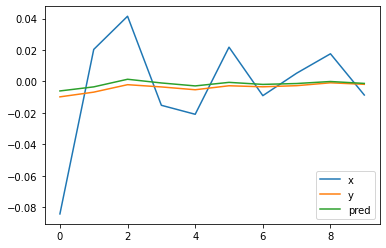

In [ ]:
# x = inputs[0].detach().numpy()*std+mean
# y = output[0].detach().numpy()*std+mean

x = data[1].cpu().detach().numpy()
y = denoised[1].cpu().detach().numpy()
pred = output[1].cpu().detach().numpy()

count = np.arange(10) 

plt.plot(count,x[0],label="x")
plt.plot(count,y.mean(axis=0),label="y")
plt.plot(count,pred.mean(axis=0),label="pred")
plt.legend()

In [ ]:
model.zero_grad()
model.eval()
log_loss=[]
total_loss = 0
for data,denoised in test_loader:
    inputs = data.to(device) 
    denoised = denoised.to(device)
    # Forward
    output = model(inputs,training=True)
    loss = loss_function(output, denoised)
    total_loss+=loss
    log_loss.append(loss)
total_loss /= len(train_loader.dataset)
print('Loss:', total_loss.item())

Loss: 1.4346722032598791e-08


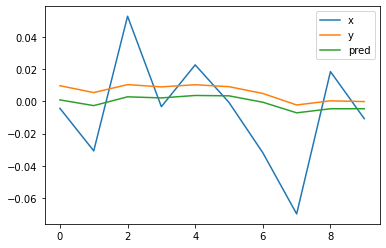

In [ ]:
x = data[1].cpu().detach().numpy()
y = denoised[1].cpu().detach().numpy()
pred = output[1].cpu().detach().numpy()

count = np.arange(10) 

plt.plot(count,x[0],label="x")
plt.plot(count,y.mean(axis=0),label="y")
plt.plot(count,pred.mean(axis=0),label="pred")
plt.legend()

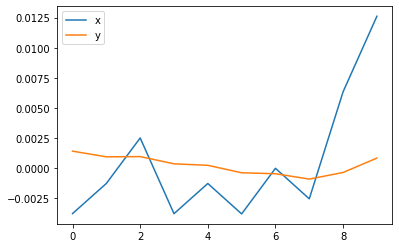

In [ ]:
for data,denoised in test_loader:
  inputs = data.to(device) 
  denoised = denoised.to(device)
  # Forward
  output = model(inputs,training=True)
  x = inputs[1].cpu().detach().numpy()
  y = output[1].cpu().detach().numpy()

  count = np.arange(10) 

  plt.plot(count,x[0],label="x")
  plt.plot(count,y.mean(axis=0),label="y")
  plt.legend()

  break

In [ ]:
def get_data(n=25):
    data_df = pd.read_csv("/content/drive/MyDrive/AI_FYP/BTCUSDT_1h.csv")
    data = data_df["close"].pct_change().dropna()
    data = data.values
    # data_sli = np.lib.stride_tricks.sliding_window_view(data,(n))
    # y = np.array([1 if arr[-1]>0  else 0 for arr in data_sli]).astype(np.float32)
    # l = data.shape[0]
    # idx = int(l*0.8)
    # data = data[idx:]

    x = data
    tmp = data
    for i in range(99):
      tmp = np.vstack((tmp,x))

    data_sli = tmp.T
    data_sli = np.lib.stride_tricks.sliding_window_view(data_sli,(n,data_sli.shape[1])).squeeze().astype(np.float32)

    y = np.array([1 if arr[-1][0]>0  else 0 for arr in data_sli]).astype(np.float32)
    return data_sli[:,:-1,:],y

x,y=get_data()
print(f'x: {x.shape}, y: {y.shape}')

In [ ]:
class PriceDataset_testing(Dataset):
    def __init__(self, input):
          self.input = torch.tensor(input)

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        x = self.input[idx].T
        return x

dset = PriceDataset_testing(x)
loader = DataLoader(dset,batch_size=BATCH_SIZE)

In [ ]:
dset[0].shape

In [ ]:
out = []
model.eval()
for data in loader:
  data = data.to(device)
  # Forward
  output = model(data,training=True)
  out.append(output.cpu().detach().numpy())

In [ ]:
denoised_x = np.concatenate(out)

In [ ]:
denoised_x=denoised_x.mean(axis=1)

In [ ]:
denoised_x

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
def train_SVM(X, y):
    from sklearn.svm import SVC
    clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    clf.fit(X, y)
    return clf
def get_acc(clf,x, y, v=False):  
    out = clf.predict(x)
    acc = np.mean(out==y)
    if v:
        print(out)
        print(y)
    return acc

l = int(denoised_x.shape[0]*0.8)
train_x,train_y = denoised_x[:l],y[:l]
test_x,test_y = denoised_x[l:],y[l:]

clf = train_SVM(train_x, train_y)
print('Denoised Input, Denoised Label\n'+'-'*60)
print(f'train_acc: {get_acc(clf, train_x, train_y):.3f}')
print(f'test_acc: {get_acc(clf, test_x, test_y):.3f}')

In [ ]:
denoised_x.shape